In [1]:
# Set full width on jupyter notebook navigator
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

# Pipeline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
dataset = pd.read_csv("./drinking_water_potability.csv")
dataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
train_set, test_set = train_test_split(
    dataset, train_size=0.75, random_state=42, stratify=dataset["Potability"]
)

target = "Potability"
feature_names = list(filter(lambda x: x != target, train_set.columns))

print(f"Elements in train: {train_set.shape[0]}")
print(f"Elements in test : {test_set.shape[0]}")
print(train_set["Potability"].value_counts() / train_set.shape[0])
print(test_set["Potability"].value_counts() / test_set.shape[0])

Elements in train: 2457
Elements in test : 819
0    0.610094
1    0.389906
Name: Potability, dtype: float64
0    0.60928
1    0.39072
Name: Potability, dtype: float64


## Removing the outliers before starting

In [5]:
from utils import process_remove_outliers_ph

processors = [process_remove_outliers_ph]

In [6]:
print("=" * 10, "TRAIN", "=" * 10)
print(f"Initial size: {train_set.shape}")
for processor in processors:
    train_set = processor(train_set)
    print(f"Apply {processor.__name__}, new size: {train_set.shape}")

print("\n" * 2, "=" * 10, "TEST", "=" * 10)
print(f"Initial size: {test_set.shape}")
for processor in processors:
    test_set = processor(test_set)
    print(f"Apply {processor.__name__}, new size: {test_set.shape}")

========== TRAIN ==========
Initial size: (2457, 10)
Apply process_remove_outliers_ph, new size: (2455, 10)


 ========== TEST ==========
Initial size: (819, 10)
Apply process_remove_outliers_ph, new size: (818, 10)


## All the transformers and steps of the pipeline

### Definition of the transformer pipeline

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transformer = Pipeline(
    [
        ("Missing_values_handler", IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)),
        ("Scaler", StandardScaler()),
    ]
)
transformer

Pipeline(steps=[('Missing_values_handler',
                 IterativeImputer(random_state=0, sample_posterior=True)),
                ('Scaler', StandardScaler())])

## Models exploration

In [10]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)

In [19]:
feature_names

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity']

In [38]:
# Add the OMS Model
from sklearn.base import BaseEstimator, ClassifierMixin
def oms_recommendation(row):
    """Check the OMS recommendations."""
    return int(6.5 <= row[1] <= 8.5 and row[7] <= 80)

scores = {"name": "OMS"}
class OMSClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        self.columns = []
        pass
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.logical_and(6.5<X[:,0], X[:,0]<8.6, X[:,7]<=80).astype(int)


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

models = [
    OMSClassifier(),
    DummyClassifier(),
    DecisionTreeClassifier(max_depth=7),
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    ExtraTreesClassifier(n_estimators=10),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

metrics = [accuracy_score, f1_score, precision_score, recall_score]
results = []

X_train, X_val, y_train, y_val = train_test_split(
    train_set[feature_names], train_set[target], train_size=0.8, random_state=20
)
for model in tqdm(models, desc="Training different models", unit="model"):
    scores = {"name": model.__class__.__name__}
    model = Pipeline([("transformer", transformer), ("model", model)])
    scores = {
        **scores,
        **{
            "cv_"
            + func.__name__: np.mean(
                cross_val_score(
                    model, X_train, y_train, cv=5, scoring=make_scorer(func)
                )
            )
            for func in metrics
        },
    }
    results.append(scores)
results_df = pd.DataFrame.from_records(results)

Training different models:   0%|          | 0/11 [00:00<?, ?model/s]/home/marco/centralesupelec/ML/ML-Drinking_Water_Potability/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/centralesupelec/ML/ML-Drinking_Water_Potability/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/centralesupelec/ML/ML-Drinking_Water_Potability/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_d

In [40]:
results_df.sort_values(by=["cv_f1_score"], ascending=False)

,name,cv_accuracy_score,cv_f1_score,cv_precision_score,cv_recall_score
5,KNeighborsClassifier,0.620163,0.421024,0.507431,0.360265
7,RandomForestClassifier,0.644603,0.402177,0.587565,0.305960
2,DecisionTreeClassifier,0.619649,0.372798,0.507550,0.294040
8,ExtraTreesClassifier,0.621693,0.351191,0.521100,0.274172
4,SVC,0.651220,0.343653,0.619196,0.238411
10,GradientBoostingClassifier,0.624260,0.322349,0.523826,0.242384
9,AdaBoostClassifier,0.603373,0.313747,0.466747,0.239735
6,GaussianNB,0.623219,0.262078,0.530682,0.174834
3,LogisticRegression,0.617616,0.010492,0.600000,0.005298
0,OMSClassifier,0.615580,0.000000,0.000000,0.000000


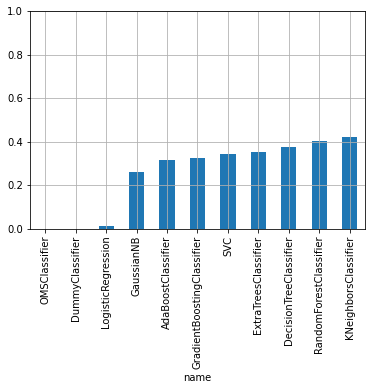

In [41]:
results_df.set_index("name")["cv_f1_score"].sort_values().plot.bar(
    ylim=[0, 1], grid=True
);

In [42]:
X_train, y_train = train_set[feature_names], train_set[target]
X_test, y_test = test_set[feature_names], test_set[target]

## Training

###  Knn

Grid search for 3 different models: SVM, Knn, RandomForest

In [43]:
MODELS = {}

In [59]:
# Knn
MODEL_DATA = {}

MODEL_DATA['param_grid'] = {
    "weights": ["uniform", "distance"],
    "n_neighbors": [1, 2, 3, 5, 7, 10]
}

MODEL_DATA['model'] = KNeighborsClassifier

MODELS['Knn'] = MODEL_DATA

In [114]:
# RandomForest
MODEL_DATA = {}

MODEL_DATA['param_grid'] = {
    "n_estimators": [10, 25, 50, 75, 100, 125, 150],
    "max_depth": [None, 3, 5, 8, 10, 15, 20, 30, 40]
}

MODEL_DATA['model'] = RandomForestClassifier

MODELS['RandomForest'] = MODEL_DATA

In [61]:
# SVM
MODEL_DATA = {}

MODEL_DATA['param_grid'] = {
    "C": [0.1, 5, 10, 20, 50],
    "kernel": ["linear", "poly", "sigmoid", "rbf"],
    "class_weight": [None, "balanced"],
}

MODEL_DATA['model'] = SVC

MODELS['SVM'] = MODEL_DATA

In [62]:
from sklearn.model_selection import GridSearchCV


def generate_results(model_name: str) -> pd.DataFrame:
    """Compute the grid search and output the results."""
    MODEL_DATA = MODELS[model_name]

    METRICS = ["f1_weighted", "accuracy", "average_precision"]

    param_grid = {"model__" + k: v for k, v in MODEL_DATA["param_grid"].items()}
    pipeline_gs = Pipeline([
        ("transformer", transformer),
        ("model", MODEL_DATA['model']())
    ])
    grid_search = GridSearchCV(
        pipeline_gs,
        param_grid=param_grid,
        cv=5,
        verbose=1,
        n_jobs=-1,
        scoring=METRICS,
        refit=False,
    )
    grid_search.fit(X_train, y_train);

    results = pd.DataFrame(grid_search.cv_results_)
    results = results.drop(columns=[x for x in results.columns if x.startswith("split")])
    results = results.sort_values(by=["mean_test_f1_weighted"], ascending=False).reset_index(
        drop=True
    )

    return results

In [63]:
# Compute the results for the 3 models

In [57]:
svm_results = generate_results("SVM")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [123]:
knn_results = generate_results('Knn')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [115]:
random_forest_results = generate_results('RandomForest')
random_forest_results['param_model__max_depth'] = random_forest_results['param_model__max_depth'].apply(lambda x: -1 if x is None else x)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


In [116]:
random_forest_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
0,1.915279,0.130758,0.673661,0.049930,40,75,"{'model__max_depth': 40, 'model__n_estimators'...",0.629281,0.011832,1,0.654175,0.011111,1,0.564168,0.018003,13
1,2.189727,0.089021,0.771826,0.049576,-1,125,"{'model__max_depth': None, 'model__n_estimator...",0.624074,0.012011,2,0.651324,0.013098,5,0.561752,0.022083,21
2,2.289481,0.187093,0.713816,0.090524,20,125,"{'model__max_depth': 20, 'model__n_estimators'...",0.623673,0.012104,3,0.653360,0.008868,2,0.571183,0.024697,3


In [124]:
knn_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,params,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
0,1.192156,0.026002,0.478627,0.044578,10,distance,"{'model__n_neighbors': 10, 'model__weights': '...",0.612331,0.011853,1,0.637067,0.008288,1,0.521875,0.020032,1
1,1.432143,0.035369,0.699507,0.011357,7,uniform,"{'model__n_neighbors': 7, 'model__weights': 'u...",0.608045,0.024128,2,0.628106,0.024256,3,0.482241,0.018720,6
2,1.408457,0.095852,0.661700,0.122093,7,distance,"{'model__n_neighbors': 7, 'model__weights': 'd...",0.607717,0.022598,3,0.627699,0.023021,4,0.513747,0.019248,2


In [118]:
svm_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_model__kernel,params,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
0,1.647030,0.024142,0.692918,0.021482,20.0,None,rbf,"{'model__C': 20, 'model__class_weight': None, ...",0.630994,0.013549,1,0.640733,0.012328,3,0.531300,0.015300,7
1,1.553260,0.058846,0.672011,0.041155,10.0,None,rbf,"{'model__C': 10, 'model__class_weight': None, ...",0.628980,0.008727,2,0.644399,0.008505,2,0.541141,0.014756,4
2,1.543707,0.032472,0.719187,0.019112,5.0,balanced,rbf,"{'model__C': 5, 'model__class_weight': 'balanc...",0.628944,0.010437,3,0.627699,0.012515,4,0.550216,0.023640,3


In [119]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def generate_graphics(results: pd.DataFrame):
    """Generate the graphics for the different params."""
    param_cols = [x for x in results.columns if x.startswith("param_model")]

    for x in param_cols:
        results[x] = results[x].apply(lambda x: "None" if x is None else x)

    fig, axes = plt.subplots(len(param_cols), 3, figsize=(20,10))
    for i, param in enumerate(param_cols):
        for j, metric in enumerate(["f1_weighted", "accuracy", "average_precision"]):
            ax  = axes[i,j]
            ax.title.set_text(f"{metric} for {param}")
            ax.set_xlabel(param)
            ax.set_ylabel(metric)

            df = results.groupby(by=[param]).mean().sort_index()
            x_values = df.index
            y_values = df[f'mean_test_{metric}']
            y_std = df[f'std_test_{metric}']

            if isinstance(results.at[0, param], (int, float, np.float64, np.int64)):
                ax.plot(x_values, y_values)
                ax.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.5)
            else:
                ax.plot(x_values, y_values)
                ax.errorbar(x_values, y_values, y_std, linestyle='None', marker='^')

            plt.tight_layout()

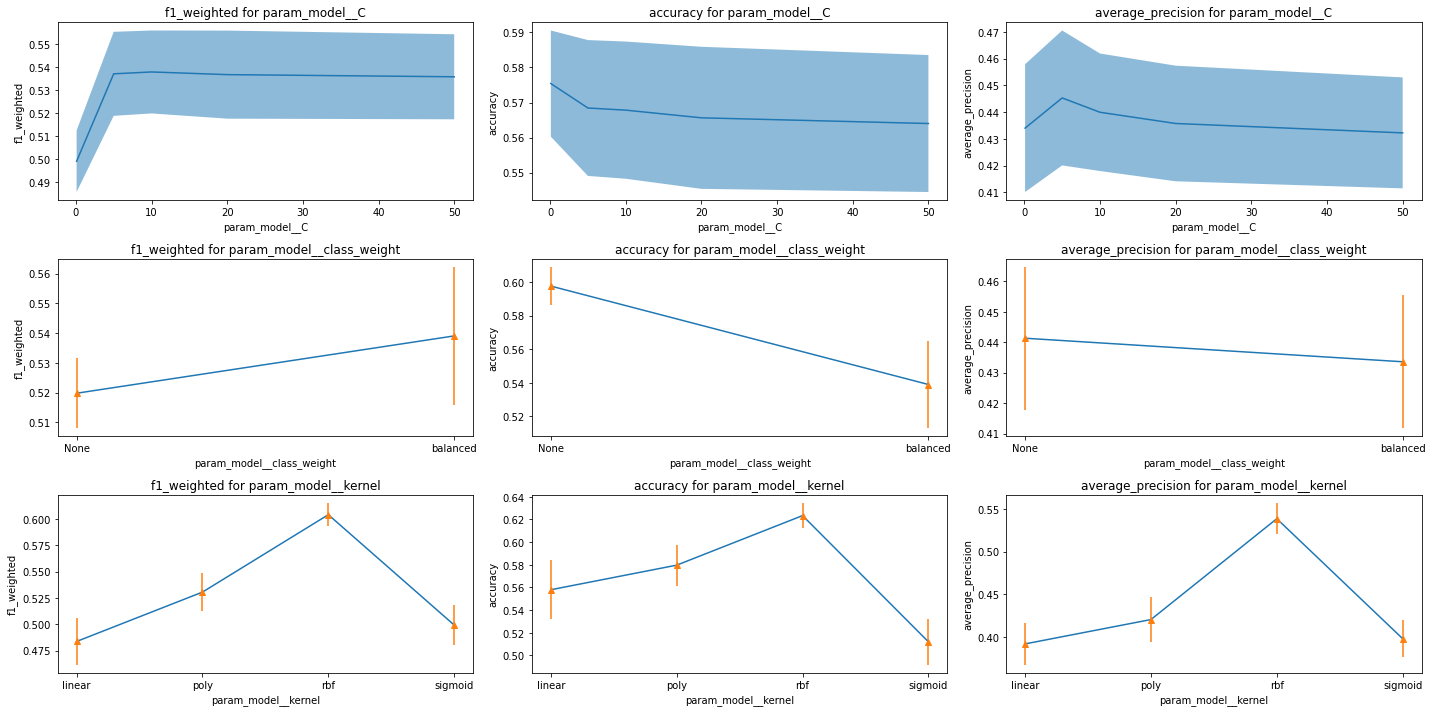

In [120]:
generate_graphics(svm_results)

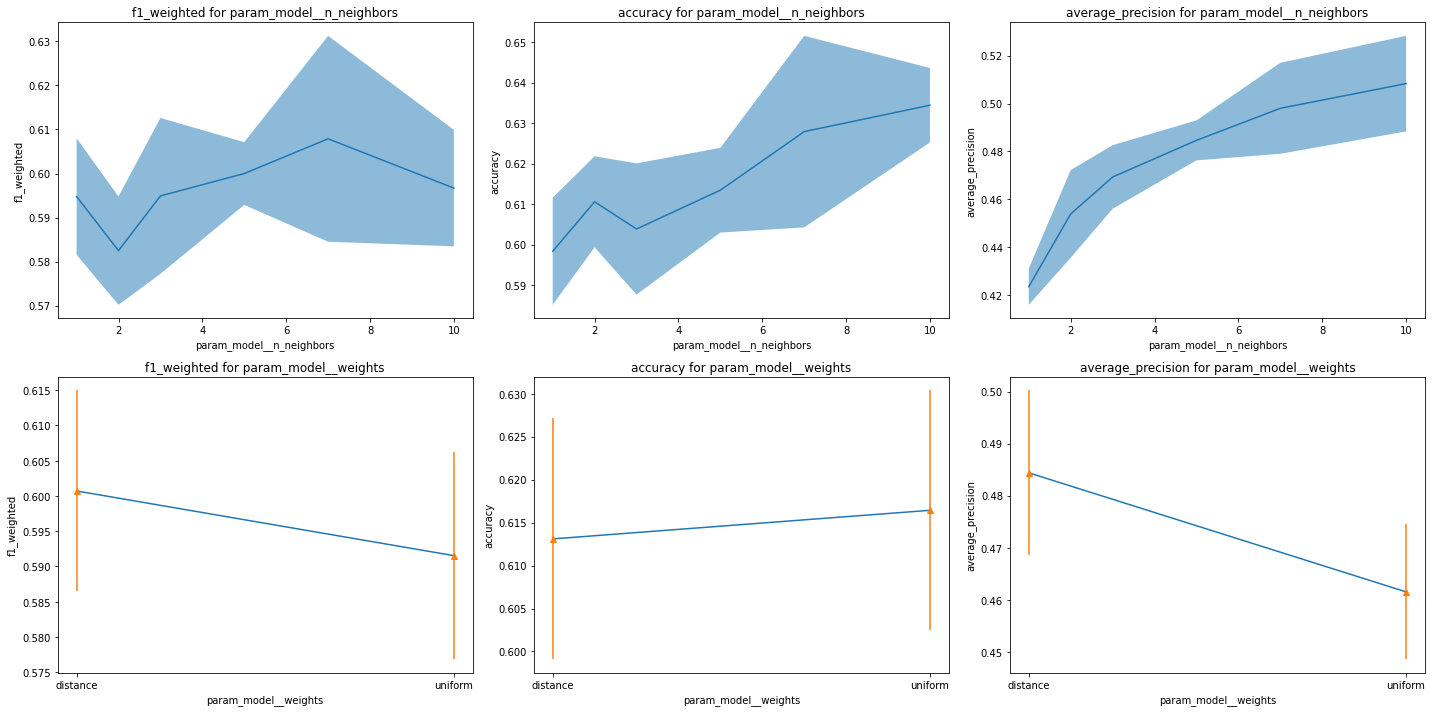

In [125]:
generate_graphics(knn_results)

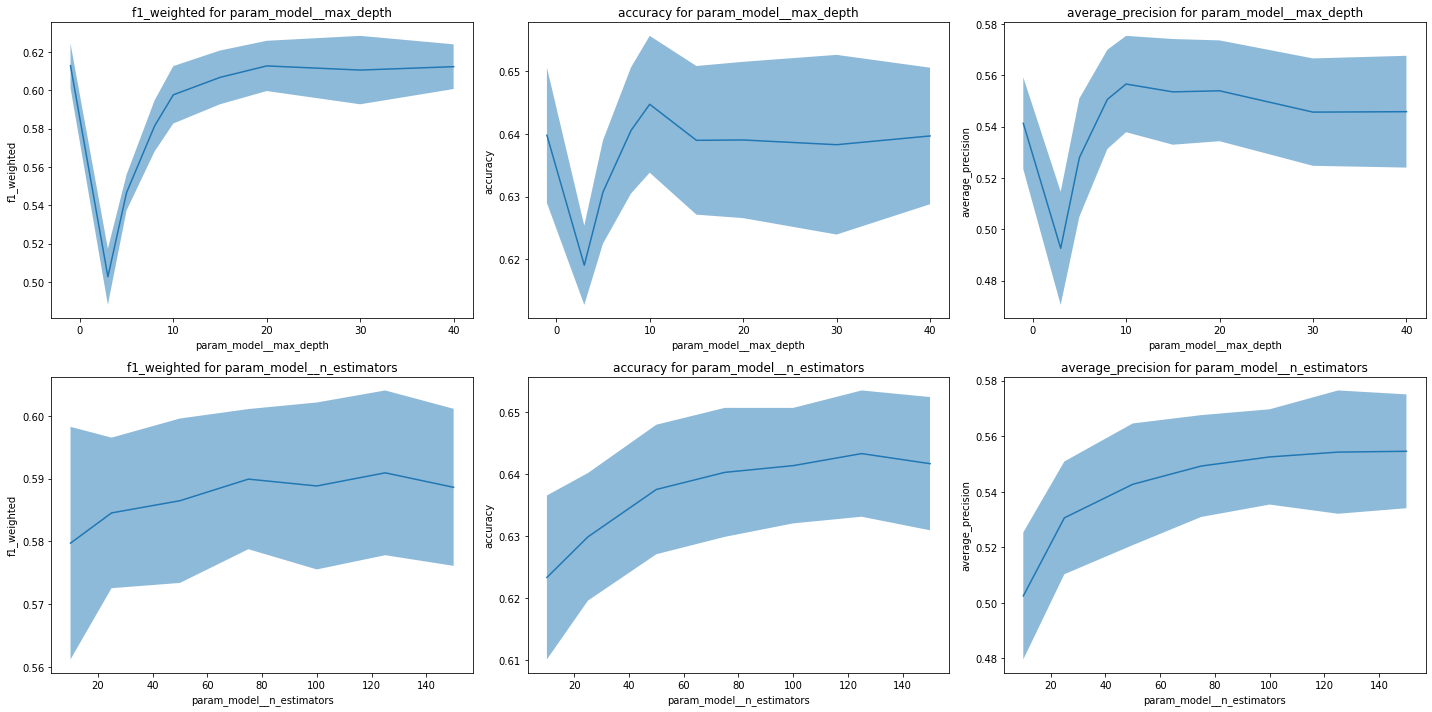

In [122]:
generate_graphics(random_forest_results)

### Final model training

In [135]:
from sklearn.ensemble import VotingClassifier
from typing import Dict, Any

In [138]:
# We select the best results

KNN_IDX = 0
SVM_IDX = 1
RAND_FOREST_IDX = 0

def replace_params(x: Dict[str, Any]) -> Dict[str, Any]:
    return {
        k.replace('model__', ""):v for k,v in x.items()
    }

In [159]:
model = VotingClassifier(
    estimators=[
        ("svc", SVC(**replace_params(svm_results.at[SVM_IDX, "params"]))),
        ("knn", KNeighborsClassifier(**replace_params(knn_results.at[SVM_IDX, "params"]))),
        ("Random_forest", RandomForestClassifier(**replace_params(random_forest_results.at[RAND_FOREST_IDX, "params"]))),
    ],
    voting="hard",
)

#model = KNeighborsClassifier(**replace_params(knn_results.at[SVM_IDX, "params"]))
#model = SVC(**replace_params(svm_results.at[SVM_IDX, "params"]))
#model = RandomForestClassifier(**replace_params(random_forest_results.at[RAND_FOREST_IDX, "params"]))


pipeline = Pipeline([("transformer", transformer), ("model", model)], verbose=True)

In [160]:
pipeline.fit(X_train, y_train)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   1.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.7s


Pipeline(steps=[('transformer',
                 Pipeline(steps=[('Missing_values_handler',
                                  IterativeImputer(random_state=0,
                                                   sample_posterior=True)),
                                 ('Scaler', StandardScaler())])),
                ('model',
                 VotingClassifier(estimators=[('svc', SVC(C=10)),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=7)),
                                              ('Random_forest',
                                               RandomForestClassifier(max_depth=40,
                                                                      n_estimators=75))]))],
         verbose=True)

### Check on training set

In [161]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1499
           1       0.93      0.68      0.78       956

    accuracy                           0.85      2455
   macro avg       0.88      0.82      0.84      2455
weighted avg       0.87      0.85      0.85      2455



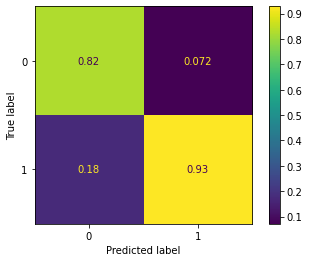

In [162]:
y_train_pred = pipeline.predict(X_train)

print(classification_report(y_train, y_train_pred))

ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, normalize="pred")).plot();

## Check on the test set

              precision    recall  f1-score   support

           0       0.66      0.87      0.75       499
           1       0.61      0.31      0.41       319

    accuracy                           0.65       818
   macro avg       0.64      0.59      0.58       818
weighted avg       0.64      0.65      0.62       818



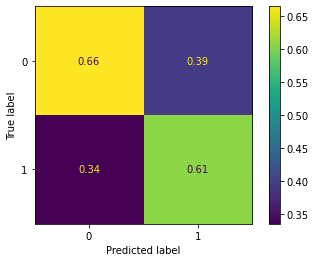

In [163]:
y_test_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred, normalize="pred")).plot();